**LIBRARIES**

2025-05-05 16:34:05.094821: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746462845.284817      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746462845.341153      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1746462858.713774      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


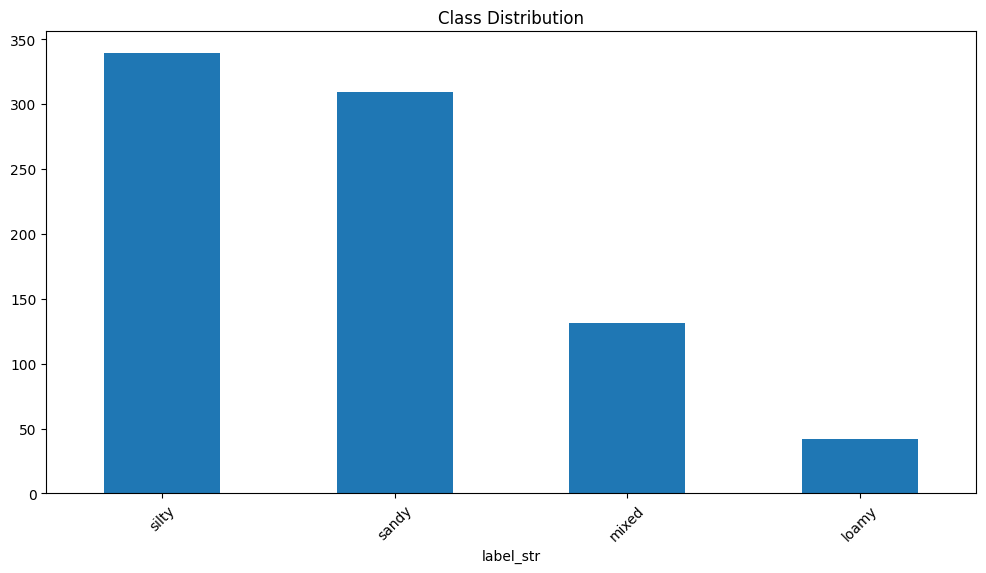


Generating geographical distribution map...


Map saved as soil_distribution_map.html

=== Phase 1: Base Model Training ===
27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/8


I0000 00:00:1746463588.652367      94 service.cc:148] XLA service 0x7bec80004930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746463588.653066      94 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746463591.297779      94 cuda_dnn.cc:529] Loaded cuDNN version 90300


 6/21 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3240 - loss: 1.3158    

I0000 00:00:1746463605.873811      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


21/21 ━━━━━━━━━━━━━━━━━━━━ 776s 2s/step - accuracy: 0.3533 - loss: 1.3099 - val_accuracy: 0.4000 - val_loss: 1.1706
Epoch 2/8


In [ ]:
import os
import re
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, applications
from tensorflow.keras import optimizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
import folium
from folium.plugins import MarkerCluster

# Configure environment
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# ─── Configuration ────────────────────────────────────────────────────────
class Config:
    DATA_PATH = '/kaggle/input/soil-distribution/model_training_img'
    PHASE1_SIZE = 160
    PHASE2_SIZE = 224
    BATCH_SIZE = 32
    FINE_TUNE_BATCH_SIZE = 16  # Reduced for memory optimization
    MIN_SAMPLES = 40
    EPOCHS_HEAD = 8
    EPOCHS_FINE = 10
    FINE_TUNE_PERCENT = 0.3
    MAP_ZOOM = 5  # For geographical visualization

# ─── Data Loading & Preparation ───────────────────────────────────────────
def load_and_prepare_data(config):
    p = Path(config.DATA_PATH)
    files = list(p.glob('**/*.jpg')) + list(p.glob('**/*.jpeg')) + list(p.glob('**/*.JPG'))
    
    records = []
    coord_pattern = re.compile(r'(-?\d+\.\d+)_(-?\d+\.\d+)')
    
    for fp in files:
        parts = fp.stem.split('_')
        try:
            # Extract coordinates from filename
            coord_match = coord_pattern.search(fp.stem)
            if not coord_match:
                continue
            lat, lon = map(float, coord_match.groups())
            
            # Extract texture label
            texture_idx = parts.index("texture")
            label = '_'.join(parts[texture_idx+1:]).lower()
            
            records.append({
                'filepath': str(fp),
                'label_str': label,
                'latitude': lat,
                'longitude': lon
            })
        except (ValueError, IndexError):
            continue

    df = pd.DataFrame(records)
    
    # Class consolidation
    consolidation_map = {
        'loamy_sand': 'sandy', 'sandy': 'sandy', 'silty_sand': 'sandy',
        'sandy_silt': 'sandy', 'combined_loamy_sand_sandy_loam': 'sandy',
        'loamy_silt': 'silty', 'clay_silt': 'silty', 
        'combined_loamy_silt_silty_loam': 'silty',
        'clay_loam': 'clay', 'clay_soil': 'clay',
        'combined_clay_loam_loamy_clay': 'clay',
        'complex_mixes': 'mixed', 'loamy_silty_sand': 'mixed',
        'silty_loamy_sand': 'mixed', 'clay_sand': 'mixed',
        'clay_silty_sand': 'mixed', 'loamy_clay_sand': 'mixed',
        'loamy_soil': 'loamy'
    }
    
    df['label_str'] = df['label_str'].map(consolidation_map).fillna('other')
    df = df[df['label_str'].isin(consolidation_map.values())]
    
    # Filter classes
    counts = df['label_str'].value_counts()
    df = df[df['label_str'].isin(counts[counts >= config.MIN_SAMPLES].index)]
    
    # Encode labels
    df['label'] = pd.Categorical(df['label_str']).codes
    label_map = dict(enumerate(df['label_str'].astype('category').cat.categories))
    
    # Plot class distribution
    plt.figure(figsize=(12,6))
    df['label_str'].value_counts().plot(kind='bar')
    plt.title('Class Distribution')
    plt.xticks(rotation=45)
    plt.show()
    
    return df.reset_index(drop=True), label_map

# ─── Geographical Visualization ───────────────────────────────────────────
def plot_soil_locations(df, label_map, zoom=5):
    print("\nGenerating geographical distribution map...")
    
    color_mapping = {
        'sandy': 'orange',
        'silty': 'blue',
        'clay': 'red',
        'loamy': 'green',
        'mixed': 'purple',
        'other': 'gray'
    }
    
    # Create base map
    m = folium.Map(
        location=[df['latitude'].mean(), df['longitude'].mean()],
        zoom_start=zoom,
        tiles='CartoDB positron'
    )
    
    # Add clustered markers
    marker_cluster = MarkerCluster().add_to(m)
    
    for _, row in df.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=4,
            color=color_mapping.get(row['label_str'], 'gray'),
            fill=True,
            fill_color=color_mapping.get(row['label_str'], 'gray'),
            popup=f"{row['label_str']}",
            tooltip=f"Coordinates: {row['latitude']:.4f}, {row['longitude']:.4f}"
        ).add_to(marker_cluster)
    
    # Save and display
    m.save('soil_distribution_map.html')
    display(m)
    print("Map saved as soil_distribution_map.html")

# ─── Optimized Data Pipeline ──────────────────────────────────────────────
class DataPipeline:
    def __init__(self, config):
        self.config = config
        self.augment = tf.keras.Sequential([
            layers.RandomFlip('horizontal'),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.15),
            layers.RandomContrast(0.1)
        ])
        
    def _process_image(self, path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        return img, label

    def create_dataset(self, df, img_size, augment=False, fine_tune=False):
        ds = tf.data.Dataset.from_tensor_slices((df['filepath'], df['label']))
        ds = ds.map(self._process_image, num_parallel_calls=tf.data.AUTOTUNE)
        
        if augment:
            ds = ds.map(
                lambda x, y: (self.augment(x), y),
                num_parallel_calls=tf.data.AUTOTUNE
            )
            
        ds = ds.map(
            lambda x, y: (
                applications.efficientnet.preprocess_input(
                    tf.image.resize(x, [img_size, img_size])
                ),
                y
            ),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        
        batch_size = self.config.FINE_TUNE_BATCH_SIZE if fine_tune else self.config.BATCH_SIZE
        return ds.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# ─── Model Architecture ───────────────────────────────────────────────────
def build_base_model(input_size, num_classes):
    base_model = applications.EfficientNetB1(
        include_top=False,
        weights='imagenet',
        input_shape=(input_size, input_size, 3),
        pooling='avg'
    )
    base_model.trainable = False
    
    inputs = layers.Input(shape=(input_size, input_size, 3))
    x = base_model(inputs)
    x = layers.Dense(256, activation='swish')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    
    return models.Model(inputs, outputs)

def create_fine_tune_model(base_model, num_classes):
    base_model.trainable = True
    # Freeze initial layers
    for layer in base_model.layers[:-30]:
        layer.trainable = False
        
    # Add new top layers
    x = base_model.output
    x = layers.Dense(192, activation='swish')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    
    return models.Model(base_model.input, outputs)

# ─── Memory-Optimized Training Workflow ───────────────────────────────────
def main():
    config = Config()
    dp = DataPipeline(config)
    
    # Load and visualize data
    df, label_map = load_and_prepare_data(config)
    plot_soil_locations(df, label_map, config.MAP_ZOOM)
    
    # Split dataset
    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'])
    val_df, test_df = train_test_split(val_df, test_size=0.3, stratify=val_df['label'])
    
    # ─── Phase 1: Base Model Training ─────────────────────────────────────
    print("\n=== Phase 1: Base Model Training ===")
    train_ds = dp.create_dataset(train_df, config.PHASE1_SIZE, augment=True)
    val_ds = dp.create_dataset(val_df, config.PHASE1_SIZE)
    
    model = build_base_model(config.PHASE1_SIZE, len(label_map))
    model.compile(
        optimizer=optimizers.AdamW(learning_rate=3e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=config.EPOCHS_HEAD,
        callbacks=[
            callbacks.EarlyStopping(patience=2, restore_best_weights=True),
            callbacks.ModelCheckpoint('phase1.keras', save_best_only=True)
        ]
    )
    
    # ─── Phase 2: Memory-Efficient Fine-Tuning ────────────────────────────
    print("\n=== Phase 2: Optimized Fine-Tuning ===")
    
    # Load base model for fine-tuning
    base_model = applications.EfficientNetB1(
        include_top=False,
        weights=None,
        input_shape=(config.PHASE2_SIZE, config.PHASE2_SIZE, 3),
        pooling='avg'
    )
    base_model.load_weights('phase1.keras')
    
    # Build fine-tune model
    model = create_fine_tune_model(base_model, len(label_map))
    model.compile(
        optimizer=optimizers.AdamW(
            learning_rate=1e-5,
            global_clipnorm=1.0  # Gradient clipping
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Prepare fine-tuning datasets
    train_ds_ft = dp.create_dataset(train_df, config.PHASE2_SIZE, augment=True, fine_tune=True)
    val_ds_ft = dp.create_dataset(val_df, config.PHASE2_SIZE, fine_tune=True)
    
    # Progressive layer unfreezing
    unfreeze_layers = reversed(base_model.layers[-30:])
    for idx, layer in enumerate(unfreeze_layers):
        layer.trainable = True
        try:
            model.fit(
                train_ds_ft.take(50),  # Partial training
                validation_data=val_ds_ft.take(20),
                epochs=1,
                verbose=0
            )
            print(f"Unfrozen layer {idx+1}/30: {layer.name}")
        except tf.errors.ResourceExhaustedError:
            layer.trainable = False
            print(f"Memory limit reached at layer {layer.name}. Stopping unfreezing.")
            break
    
    # Full fine-tuning
    history = model.fit(
        train_ds_ft,
        validation_data=val_ds_ft,
        epochs=config.EPOCHS_FINE,
        callbacks=[
            callbacks.EarlyStopping(patience=3, monitor='val_loss'),
            callbacks.ReduceLROnPlateau(factor=0.5, patience=1),
            callbacks.ModelCheckpoint('final_model.keras', save_best_only=True)
        ]
    )
    
    # ─── Final Evaluation ────────────────────────────────────────────────
    print("\n=== Final Evaluation ===")
    test_ds = dp.create_dataset(test_df, config.PHASE2_SIZE)
    model.load_weights('final_model.keras')
    loss, acc = model.evaluate(test_ds)
    print(f"Test Accuracy: {acc:.4f}, Loss: {loss:.4f}")

if __name__ == '__main__':
    main()